In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import importlib
import statsmodels.api as sm
import seaborn as sns; sns.set_theme(color_codes=True)

In [2]:
data = pd.read_csv('funds_price_history_stacked.csv')
data.drop(columns='Unnamed: 4', inplace=True)
data = data.rename(columns={'Value':'Price'})
data['Date'] = pd.to_datetime(data['Date'])
data

,MStarID,FundName,Date,Price
0,F0000113ES,Morningstar US 1-5Y Tsy&Gv Bd TR USD,2022-01-02,207.53400
1,F0000113ES,Morningstar US 1-5Y Tsy&Gv Bd TR USD,2022-01-01,207.53400
2,F0000113ES,Morningstar US 1-5Y Tsy&Gv Bd TR USD,2021-12-31,207.53400
3,F0000113ES,Morningstar US 1-5Y Tsy&Gv Bd TR USD,2021-12-30,207.47379
4,F0000113ES,Morningstar US 1-5Y Tsy&Gv Bd TR USD,2021-12-29,207.38144
...,...,...,...,...
43212,F00000O00R,iShares Short Maturity Bond ETF,2013-09-29,50.01000
43213,F00000O00R,iShares Short Maturity Bond ETF,2013-09-28,50.01000
43214,F00000O00R,iShares Short Maturity Bond ETF,2013-09-27,50.01000
43215,F00000O00R,iShares Short Maturity Bond ETF,2013-09-26,50.00000


# 1. Finding the correct benchmark

### Using correlation analysis of monthly data

In [3]:
def extract_daily(df):
    df = df.sort_values(by='Date')
    df['Returns'] = (df['Price'] - df['Price'].shift(1)) / df['Price'].shift(1)
    return df

def extract_monthly(df):
    df = df.sort_values(by='Date')
    df['Returns'] = (df['Price'] - df['Price'].shift(1)) / df['Price'].shift(1)
    df['Returns'] = df['Returns'].fillna(0) + 1
    df.set_index('Date', inplace=True)
    df = df.resample('M').apply({
        'MStarID': 'last',
        'FundName': 'last',
        'Price': 'last',
        'Returns': 'prod'
    })
    df['Returns'] = df['Returns'] - 1
    df.reset_index(inplace=True)
    return df

def extract_weekly(df):
    df = df.sort_values(by='Date')
    df['Returns'] = (df['Price'] - df['Price'].shift(1)) / df['Price'].shift(1)
    df['Returns'] = df['Returns'].fillna(0) + 1
    df.set_index('Date', inplace=True)
    df = df.resample('W-MON').apply({
        'MStarID': 'last',
        'FundName': 'last',
        'Price': 'last',
        'Returns': 'prod'
    })
    df['Returns'] = df['Returns'] - 1
    df.reset_index(inplace=True)
    return df

In [4]:
groups = data.groupby('MStarID')
etf = groups.get_group('F00000O00R').copy()
etf = extract_monthly(etf)
etf.rename(columns={'Price': 'ETF_Price', 'Returns': 'ETF_Returns'}, inplace=True)
etf.drop(columns=['FundName', 'MStarID'], inplace=True)
etf

,Date,ETF_Price,ETF_Returns
0,2013-09-30,50.01000,0.000200
1,2013-10-31,50.07000,0.001200
2,2013-11-30,50.14456,0.001489
3,2013-12-31,50.16370,0.000382
4,2014-01-31,50.23380,0.001397
...,...,...,...
96,2021-09-30,56.22083,0.000169
97,2021-10-31,56.17577,-0.000801
98,2021-11-30,56.14134,-0.000613
99,2021-12-31,56.13732,-0.000072


In [5]:
for fund_id, group in groups:
    print(fund_id, end= ' ')
    monthly_data = pd.merge(etf, extract_monthly(group), on=['Date'], how='inner')
    print(f"Price Correlation: {monthly_data['Price'].corr(monthly_data['ETF_Price'])}", end=' ')
    print(f"Return Correlation: {monthly_data['Returns'].corr(monthly_data['ETF_Returns'])}")

F00000O00R Price Correlation: 1.0 Return Correlation: 0.9999999999999998
F0000113ES Price Correlation: 0.9519169859418954 Return Correlation: -0.2020403310791361
F0000113ET Price Correlation: 0.9861859672467136 Return Correlation: 0.8449379391269307
F0000113EU Price Correlation: 0.9700671701072754 Return Correlation: 0.18202294213057907
F0000113F2 Price Correlation: 0.974618861421109 Return Correlation: -0.06956009323569091
F0000113FW Price Correlation: 0.9749374215983598 Return Correlation: 0.18157153907109352


Both, the highest price correlation and highest returns correlation of the ETF is for F0000113ET 

### Running regression on daily prices

In [6]:
groups = data.groupby('MStarID')
etf = groups.get_group('F00000O00R').copy()
etf.drop(columns=['MStarID', 'FundName'], inplace=True)
etf.rename(columns={'Price': 'ETF_Price'}, inplace=True)
etf = etf.sort_values(by='Date')
etf

,Date,ETF_Price
43216,2013-09-25,50.00000
43215,2013-09-26,50.00000
43214,2013-09-27,50.01000
43213,2013-09-28,50.01000
43212,2013-09-29,50.01000
...,...,...
40199,2021-12-29,56.12608
40198,2021-12-30,56.13732
40197,2021-12-31,56.13732
40196,2022-01-01,56.13732


In [7]:
groups = data.groupby('MStarID')
etf = groups.get_group('F00000O00R').sort_values(by='Date')
etf.drop(columns=['MStarID', 'FundName'], inplace=True)
etf.rename(columns={'Price': 'ETF_Price'}, inplace=True)
for fund_id, group in groups:
    print("\n\n")
    print(f'{fund_id} {group["FundName"].values[0]}')
    df = pd.merge(group.sort_values(by='Date'), etf, on='Date', how='inner')
    X = sm.add_constant(df['Price'])
    Y = df['ETF_Price']
    model = sm.OLS(Y, X).fit()
    print(model.summary())




F00000O00R iShares Short Maturity Bond ETF
                            OLS Regression Results                            
Dep. Variable:              ETF_Price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.293e+29
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:46:34   Log-Likelihood:                 82696.
No. Observations:                3022   AIC:                        -1.654e+05
Df Residuals:                    3020   BIC:                        -1.654e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

### Rationale for benchmark choice
- The correlations of monthly returns and prices both are maximum for the iShares ETF and F0000113ET Morningstar US 1-5Y Corp Bd TR USD
- Using monthly returns reduces noise and short-term volatility, providing a clearer view of long-term trends and correlations. 
- Running OLS gives us statistically significant coefficients for all benchmarks vs the ETF. This implies that there is clear relationship between ETF and all benchmarks.
- However even with OLS F0000113ET Morningstar US 1-5Y Corp Bd TR USD is the best benchmark out of all the options. The R-squared is maximum (0.97) for F0000113ET which implies that it explains 97% of the variance of NEAR returns.

### Construction of a composite benchmark
- We can take this up a notch and construct a composite benchmark consisting of all the index 
- For simplicity lets keep this composite benchmark static. If its dynamic we would have to adjust for forward bias and introduce appropriate weekly/monthly rebalancing
- We can use monthly, daily or weekly returns to determine the composite. Lets go with weekly
- We run a multivariate regression of NEAR weekly returns against the weekly returns of all indexes
- The composite can be constructed by wieghing each index in the ratio of their respective coefficients

In [8]:
groups = data.groupby('MStarID')
merged_df = pd.DataFrame()
for fund_id, group in groups:
    df = group.sort_values(by='Date')
    df = extract_weekly(df)
    df.rename(columns={'Price': f'{fund_id}_Price', 'Returns': f'{fund_id}_Returns'}, inplace=True)
    df.drop(columns=['FundName', 'MStarID'], inplace=True)
    if len(merged_df) == 0:
        merged_df = df
    else:
        merged_df = pd.merge(df, merged_df, on='Date', how='inner')
merged_df

,Date,F0000113FW_Price,F0000113FW_Returns,F0000113F2_Price,F0000113F2_Returns,F0000113EU_Price,F0000113EU_Returns,F0000113ET_Price,F0000113ET_Returns,F0000113ES_Price,F0000113ES_Returns,F00000O00R_Price,F00000O00R_Returns
0,2013-09-30,175.56505,0.000576,132.01625,-0.000005,192.54321,0.001588,207.85594,0.001643,182.46112,0.001606,50.01000,0.000200
1,2013-10-07,175.54692,-0.000103,132.01379,-0.000019,192.56351,0.000105,208.01346,0.000758,182.41022,-0.000279,50.02000,0.000200
2,2013-10-14,175.57928,0.000184,131.99925,-0.000110,192.62204,0.000304,208.17677,0.000785,182.43179,0.000118,50.01000,-0.000200
3,2013-10-21,175.73897,0.000910,132.01912,0.000151,192.91776,0.001535,208.78392,0.002917,182.67720,0.001345,50.03000,0.000400
4,2013-10-28,175.82875,0.000511,132.02019,0.000008,193.19379,0.001431,209.24982,0.002231,182.89801,0.001209,50.05000,0.000400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,2021-12-06,197.97490,-0.001924,139.68875,0.000024,224.84357,-0.001757,258.99561,-0.001447,207.62973,-0.002073,56.11533,-0.000663
428,2021-12-13,197.95644,-0.000093,139.69025,0.000011,224.85707,0.000060,259.16266,0.000645,207.58463,-0.000217,56.11533,0.000000
429,2021-12-20,198.06935,0.000570,139.69147,0.000009,225.09491,0.001058,259.45041,0.001110,207.83501,0.001206,56.11485,-0.000009
430,2021-12-27,197.83632,-0.001177,139.69217,0.000005,224.74313,-0.001563,259.18967,-0.001005,207.39948,-0.002096,56.11485,0.000000


#### It is fair to assume that there is going to be high multicollinearity among all the merged df return series hence we will use ridge regression instead of OLS because OLS will give unstable results

In [9]:
Y = merged_df['F00000O00R_Returns']
X = merged_df[['F0000113FW_Returns', 'F0000113F2_Returns', 'F0000113EU_Returns', 'F0000113ET_Returns', 'F0000113ES_Returns']]
X = sm.add_constant(X)
alpha = 3.8
model = sm.OLS(Y, X)
ridge_results = model.fit_regularized(alpha=alpha, L1_wt=0.0)
weights = np.array(ridge_results.params[1:])
weights_normalized = weights / weights.sum()
weights_df = pd.DataFrame({
    'MStarID': ['F0000113FW', 'F0000113F2', 'F0000113EU', 'F0000113ET', 'F0000113ES'],
    'CompositeWt': weights_normalized
})
weights_df

,MStarID,CompositeWt
0,F0000113FW,0.141633
1,F0000113F2,0.001522
2,F0000113EU,0.172599
3,F0000113ET,0.658767
4,F0000113ES,0.025479


In [10]:
groups = data.groupby('MStarID')
composite_daily = pd.DataFrame(columns=['Date', 'BMK_Price', 'BMK_Returns'])
composite_daily['Date'] = groups.get_group('F00000O00R').sort_values(by='Date')['Date']
composite_daily.fillna(0, inplace=True)

composite_monthly = pd.DataFrame(columns=['Date', 'BMK_Price', 'BMK_Returns'])
composite_monthly['Date'] = extract_monthly(groups.get_group('F00000O00R')).sort_values(by='Date')['Date']
composite_monthly.fillna(0, inplace=True)

composite_weekly = pd.DataFrame(columns=['Date', 'BMK_Price', 'BMK_Returns'])
composite_weekly['Date'] = extract_weekly(groups.get_group('F00000O00R')).sort_values(by='Date')['Date']
composite_weekly.fillna(0, inplace=True)

for fund_id, group in groups:
    if fund_id != 'F00000O00R':
        daily_df = pd.merge(extract_daily(group), weights_df, on='MStarID', how='inner')
        weekly_df = pd.merge(extract_weekly(group), weights_df, on='MStarID', how='inner')
        monthly_df = pd.merge(extract_monthly(group), weights_df, on='MStarID', how='inner')
        
        composite_daily = pd.merge(composite_daily, daily_df, on='Date', how='inner')
        composite_daily['BMK_Price'] = composite_daily['BMK_Price'] + (composite_daily['Price'] * composite_daily['CompositeWt'])
        composite_daily['BMK_Returns'] = composite_daily['BMK_Returns'] + (composite_daily['Returns'] * composite_daily['CompositeWt'])
        composite_daily = composite_daily[['Date', 'BMK_Price', 'BMK_Returns']]
        
        composite_weekly = pd.merge(composite_weekly, weekly_df, on='Date', how='inner')
        composite_weekly['BMK_Price'] = composite_weekly['BMK_Price'] + (composite_weekly['Price'] * composite_weekly['CompositeWt'])
        composite_weekly['BMK_Returns'] = composite_weekly['BMK_Returns'] + (composite_weekly['Returns'] * composite_weekly['CompositeWt'])
        composite_weekly = composite_weekly[['Date', 'BMK_Price', 'BMK_Returns']]
        
        composite_monthly = pd.merge(composite_monthly, monthly_df, on='Date', how='inner')
        composite_monthly['BMK_Price'] = composite_monthly['BMK_Price'] + (composite_monthly['Price'] * composite_monthly['CompositeWt'])
        composite_monthly['BMK_Returns'] = composite_monthly['BMK_Returns'] + (composite_monthly['Returns'] * composite_monthly['CompositeWt'])
        composite_monthly = composite_monthly[['Date', 'BMK_Price', 'BMK_Returns']]

composite_daily

,Date,BMK_Price,BMK_Returns
0,2013-09-25,199.865678,0.000607
1,2013-09-26,199.801514,-0.000317
2,2013-09-27,199.908784,0.000529
3,2013-09-28,199.908784,0.000000
4,2013-09-29,199.908784,0.000000
...,...,...,...
3017,2021-12-29,243.066290,-0.000347
3018,2021-12-30,243.169391,0.000412
3019,2021-12-31,243.238018,0.000278
3020,2022-01-01,243.238018,0.000000


# 2. Graph the performance of ETF vs Benchmark

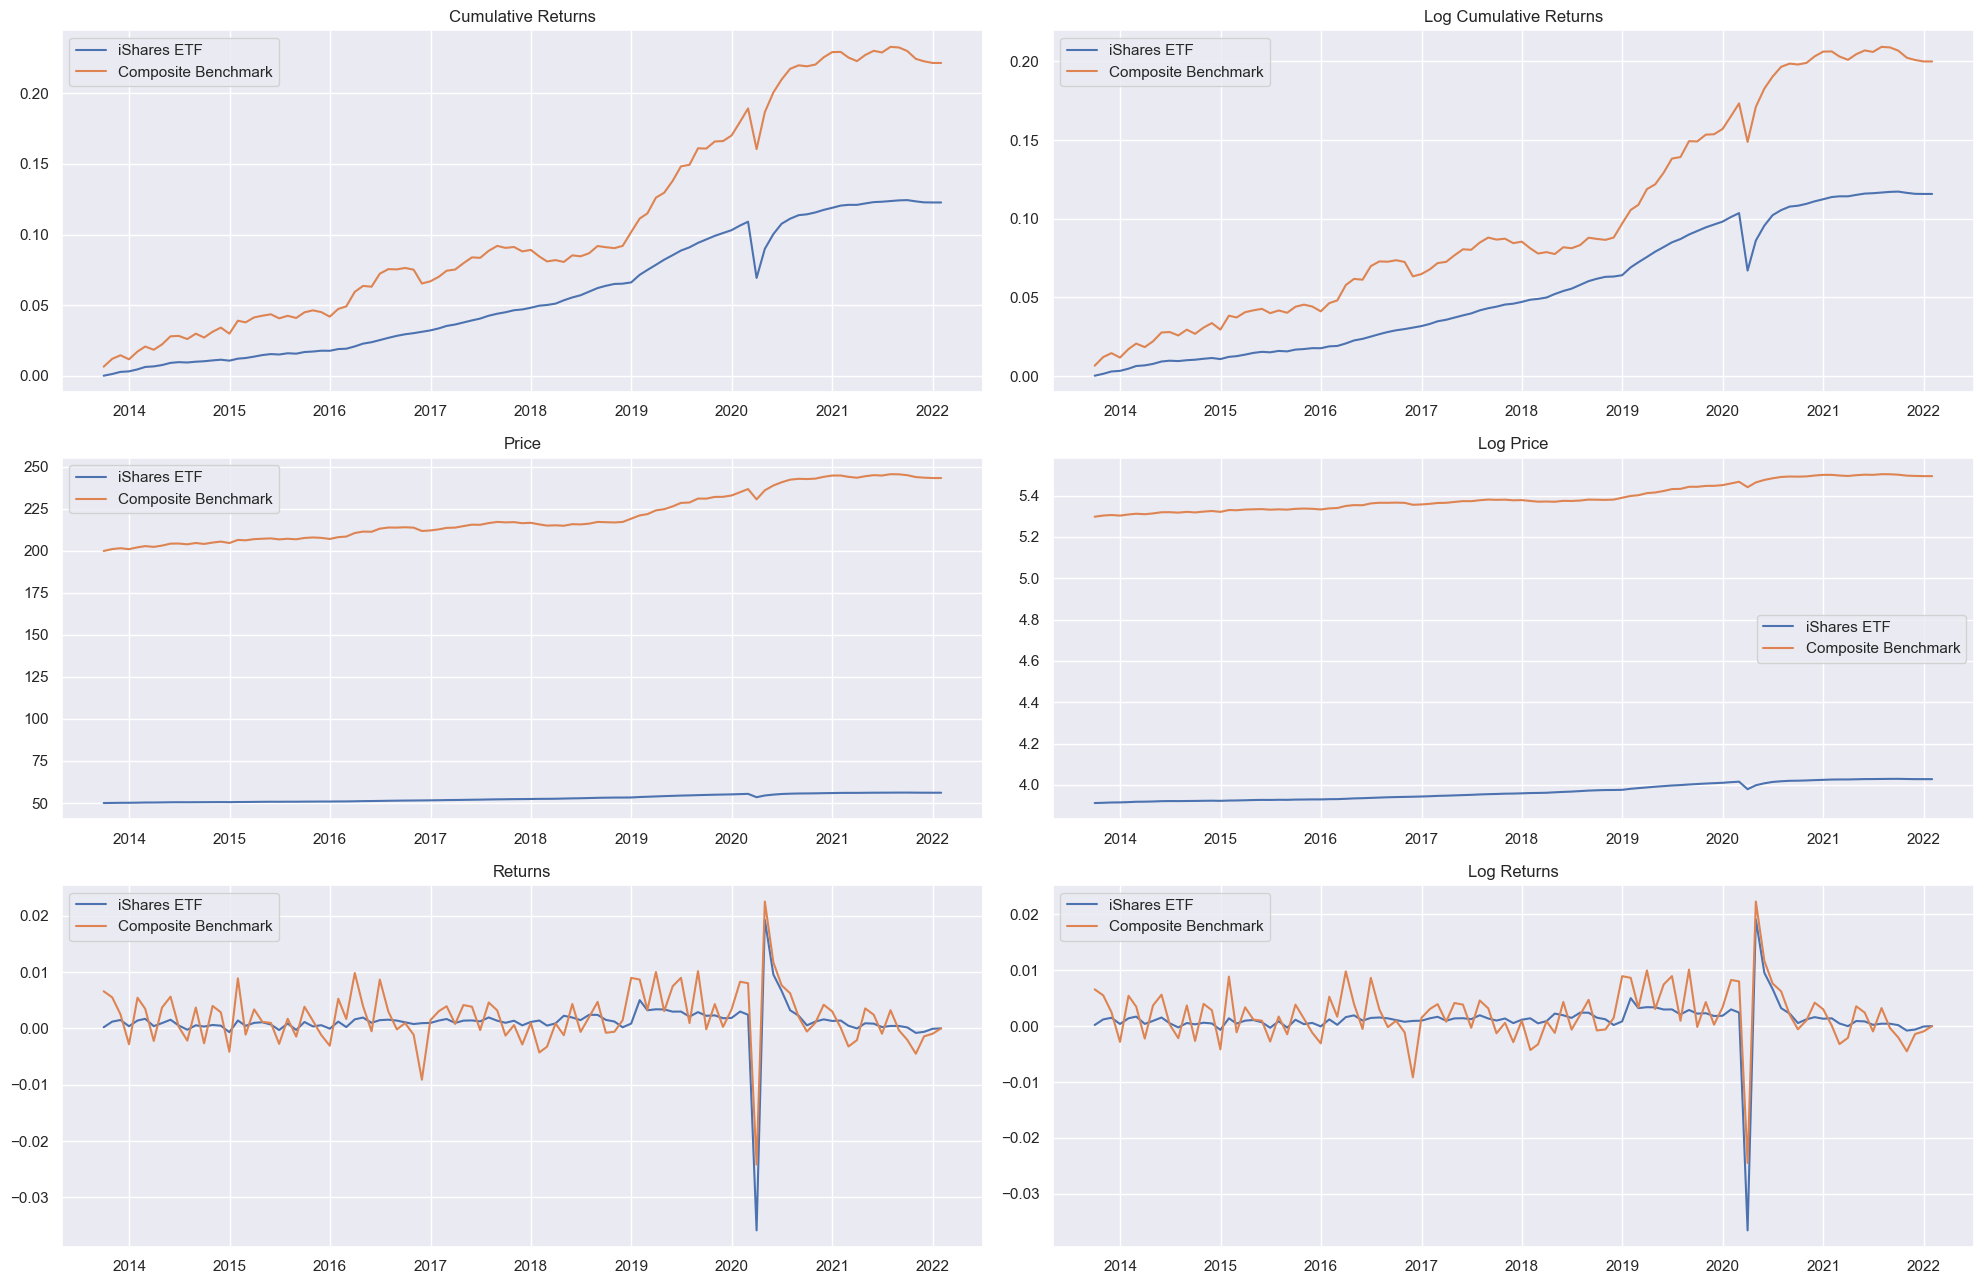

In [11]:
groups = data.groupby('MStarID')
etf = groups.get_group('F00000O00R').copy()
etf = extract_monthly(etf)
etf.rename(columns={'Price': 'ETF_Price', 'Returns': 'ETF_Returns'}, inplace=True)
etf.drop(columns=['FundName', 'MStarID'], inplace=True)

bmk = composite_monthly.copy()

merged_df = pd.merge(bmk, etf, on='Date', how='inner')
merged_df['BMK_CumRet'] = (1 + merged_df['BMK_Returns']).cumprod() - 1
merged_df['ETF_CumRet'] = (1 + merged_df['ETF_Returns']).cumprod() - 1

fig, axes = plt.subplots(3, 2, figsize=(20, 13))

axes[0,0].set_title('Cumulative Returns')
axes[0,0].plot(merged_df['Date'], merged_df['ETF_CumRet'], label="iShares ETF")
axes[0,0].plot(merged_df['Date'], merged_df['BMK_CumRet'], label='Composite Benchmark')
axes[0,0].legend()

axes[0,1].set_title('Log Cumulative Returns')
axes[0,1].plot(merged_df['Date'], np.log(1+merged_df['ETF_CumRet']), label="iShares ETF")
axes[0,1].plot(merged_df['Date'], np.log(1+merged_df['BMK_CumRet']), label='Composite Benchmark')
axes[0,1].legend()

axes[1,0].set_title('Price')
axes[1,0].plot(merged_df['Date'], merged_df['ETF_Price'], label="iShares ETF")
axes[1,0].plot(merged_df['Date'], merged_df['BMK_Price'], label='Composite Benchmark')
axes[1,0].legend()

axes[1,1].set_title('Log Price')
axes[1,1].plot(merged_df['Date'], np.log(merged_df['ETF_Price']), label="iShares ETF")
axes[1,1].plot(merged_df['Date'], np.log(merged_df['BMK_Price']), label='Composite Benchmark')
axes[1,1].legend()

axes[2,0].set_title('Returns')
axes[2,0].plot(merged_df['Date'], merged_df['ETF_Returns'], label="iShares ETF")
axes[2,0].plot(merged_df['Date'], merged_df['BMK_Returns'], label='Composite Benchmark')
axes[2,0].legend()

axes[2,1].set_title('Log Returns')
axes[2,1].plot(merged_df['Date'], np.log(1 + merged_df['ETF_Returns']), label="iShares ETF")
axes[2,1].plot(merged_df['Date'], np.log(1 + merged_df['BMK_Returns']), label='Composite Benchmark')
axes[2,1].legend()

plt.tight_layout()

# 3. Comparative Statistics

### (a) Annualized Return and volatility

In [12]:
bmk_id = 'F0000113ET'
etf_id = 'F00000O00R'

groups = data.groupby('MStarID')
# bmk = extract_daily(groups.get_group(bmk_id))
# bmk.drop(columns=['MStarID', 'FundName'], inplace=True)
# bmk.rename(columns={'Price': 'BMK_Price', 'Returns':'BMK_Returns'}, inplace=True)
bmk = composite_daily.copy()

etf = extract_daily(groups.get_group(etf_id))
etf.drop(columns=['MStarID', 'FundName'], inplace=True)
etf.rename(columns={'Price': 'ETF_Price', 'Returns':'ETF_Returns'}, inplace=True)

merged_df = pd.merge(bmk, etf, on='Date', how='inner').sort_values('Date')
merged_df.fillna(0, inplace=True)
merged_df

,Date,BMK_Price,BMK_Returns,ETF_Price,ETF_Returns
0,2013-09-25,199.865678,0.000607,50.00000,0.0000
1,2013-09-26,199.801514,-0.000317,50.00000,0.0000
2,2013-09-27,199.908784,0.000529,50.01000,0.0002
3,2013-09-28,199.908784,0.000000,50.01000,0.0000
4,2013-09-29,199.908784,0.000000,50.01000,0.0000
...,...,...,...,...,...
3017,2021-12-29,243.066290,-0.000347,56.12608,0.0000
3018,2021-12-30,243.169391,0.000412,56.13732,0.0002
3019,2021-12-31,243.238018,0.000278,56.13732,0.0000
3020,2022-01-01,243.238018,0.000000,56.13732,0.0000


In [13]:
def calc_annualized_return(ret_series):
    tot_returns = (1 + ret_series).prod() - 1
    return tot_returns

def calc_annualized_vol(ret_series):
    vol = ret_series.std()
    vol = vol * np.sqrt(252)
    return vol

tuple_list = []
merged_df['Year'] = merged_df['Date'].dt.year
groups = merged_df.groupby('Year')
for year, group in groups:
    if year < 2022:
        ann_ret_bmk = calc_annualized_return(group['BMK_Returns'])
        ann_ret_etf = calc_annualized_return(group['ETF_Returns'])
        ann_vol_bmk = calc_annualized_vol(group['BMK_Returns'])
        ann_vol_etf = calc_annualized_vol(group['ETF_Returns'])
        tuple_list.append((year, ann_ret_bmk, ann_ret_etf, ann_vol_bmk, ann_vol_etf))

tuple_list.append(('Total', calc_annualized_return(merged_df['BMK_Returns']), calc_annualized_return(merged_df['ETF_Returns']), calc_annualized_vol(merged_df['BMK_Returns']), calc_annualized_vol(merged_df['ETF_Returns'])))
output_df = pd.DataFrame(tuple_list, columns=['Period', 'Returns Benchmark (APR %)', 'Returns ETF (APR %)', 'Annualized Volatility Benchmark', 'Annualized Volatility ETF'])
output_df['Returns Benchmark (APR %)'] = output_df['Returns Benchmark (APR %)'] * 100
output_df['Returns ETF (APR %)'] = output_df['Returns ETF (APR %)'] * 100
output_df

,Period,Returns Benchmark (APR %),Returns ETF (APR %),Annualized Volatility Benchmark,Annualized Volatility ETF
0,2013,0.584732,0.327400,0.008704,0.002715
1,2014,1.792873,0.753653,0.010019,0.002391
2,2015,1.168512,0.691270,0.012699,0.002074
3,2016,2.398306,1.417830,0.010829,0.001716
4,2017,2.082706,1.550646,0.009037,0.001760
5,2018,1.158348,1.711769,0.009180,0.002073
6,2019,6.197948,3.465565,0.012808,0.002435
7,2020,5.020518,1.433725,0.022216,0.020822
8,2021,-0.625204,0.337453,0.009191,0.001838
9,Total,21.397013,12.274640,0.012587,0.007506


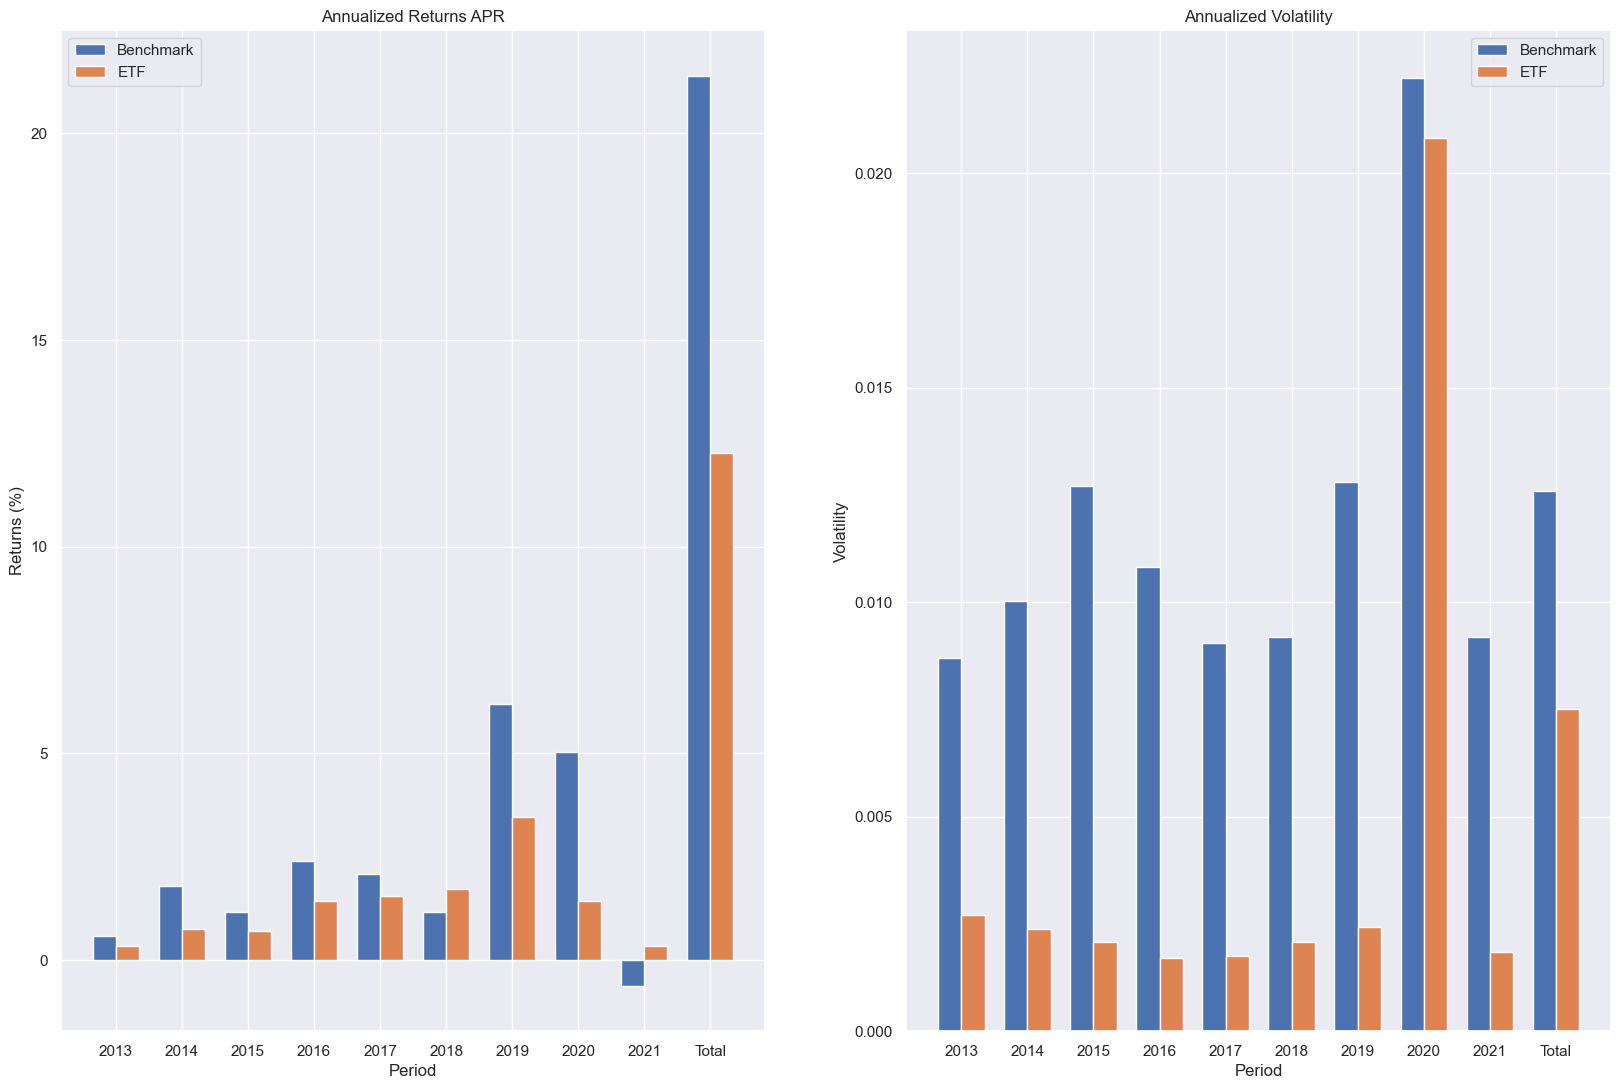

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 13))

axes[0].set_title('Annualized Returns APR')
bar_width = 0.35
x = np.arange(len(output_df['Period']))
axes[0].bar(x - bar_width/2, output_df['Returns Benchmark (APR %)'], bar_width, label='Benchmark')
axes[0].bar(x + bar_width/2, output_df['Returns ETF (APR %)'], bar_width, label='ETF')

# Add labels, title, and legend
axes[0].set_xlabel('Period')
axes[0].set_ylabel('Returns (%)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(output_df['Period'])
axes[0].legend()


axes[1].set_title('Annualized Volatility')
bar_width = 0.35
x = np.arange(len(output_df['Period']))
axes[1].bar(x - bar_width/2, output_df['Annualized Volatility Benchmark'], bar_width, label='Benchmark')
axes[1].bar(x + bar_width/2, output_df['Annualized Volatility ETF'], bar_width, label='ETF')

# Add labels, title, and legend
axes[1].set_xlabel('Period')
axes[1].set_ylabel('Volatility')
axes[1].set_xticks(x)
axes[1].set_xticklabels(output_df['Period'])
axes[1].legend()

plt.show()

### (b) Maximum Drawdown

In [15]:
def calc_dd(price_ser):
    prices = price_ser.values
    max_price = prices[0]
    max_drawdown = 0
    for price in prices:
        if price > max_price:
            max_price = price
        dd = abs(max_price - price)/max_price
        max_drawdown = max(dd, max_drawdown)
    return max_drawdown * 100

tuple_list = []
merged_df['Year'] = merged_df['Date'].dt.year
groups = merged_df.groupby('Year')
for year, group in groups:
    if year < 2022:
        bmk_dd = calc_dd(group['BMK_Price'])
        etf_dd = calc_dd(group['ETF_Price'])
        tuple_list.append((year, bmk_dd, etf_dd))
tuple_list.append(('Total', calc_dd(merged_df['BMK_Price']), calc_dd(merged_df['ETF_Price'])))
output = pd.DataFrame(tuple_list, columns=['Period', 'Max Drawdown (%) BMK', 'Max Drawdown (%) ETF'])
output_df = pd.merge(output_df, output, on='Period', how='inner')
output

,Period,Max Drawdown (%) BMK,Max Drawdown (%) ETF
0,2013,0.405278,0.059952
1,2014,0.907218,0.122811
2,2015,0.808648,0.060017
3,2016,1.446282,0.040009
4,2017,0.600259,0.039861
5,2018,0.968301,0.137559
6,2019,0.806163,0.059708
7,2020,5.936630,5.640517
8,2021,1.229388,0.227202
9,Total,5.936630,5.640517


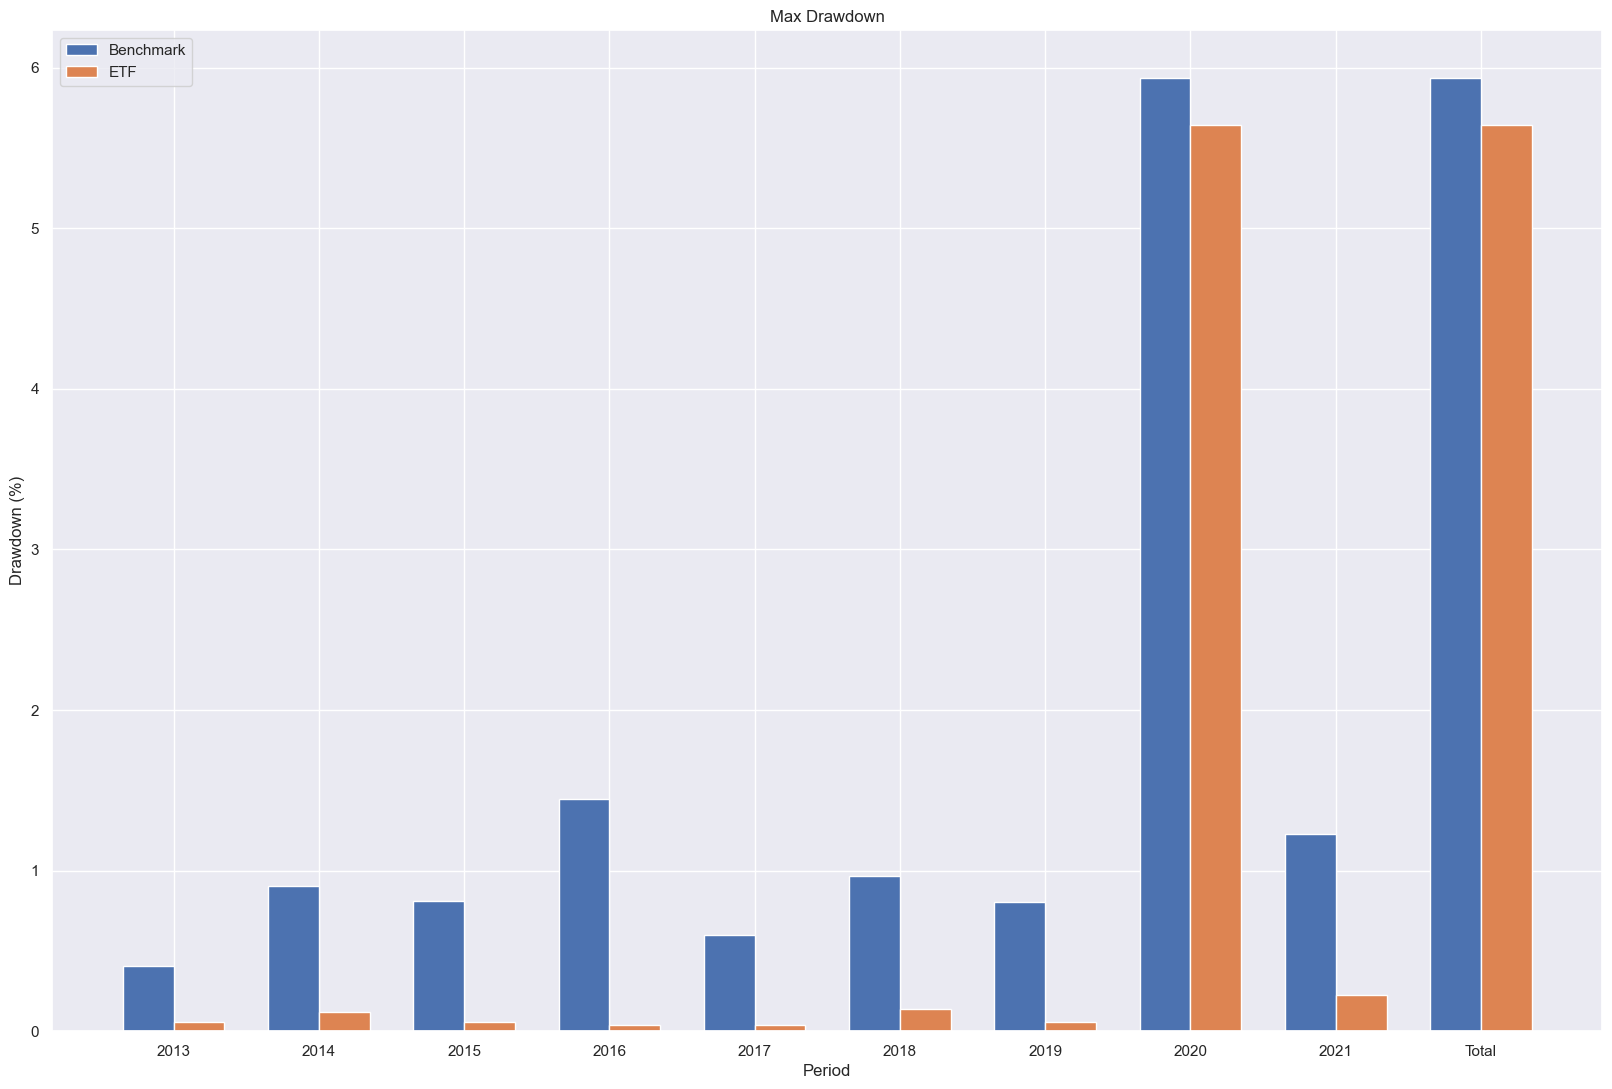

In [16]:
plt.figure(figsize=(20,13))
plt.title('Max Drawdown')
bar_width = 0.35
x = np.arange(len(output_df['Period']))
plt.bar(x - bar_width/2, output_df['Max Drawdown (%) BMK'], bar_width, label='Benchmark')
plt.bar(x + bar_width/2, output_df['Max Drawdown (%) ETF'], bar_width, label='ETF')

# Add labels, title, and legend
plt.xlabel('Period')
plt.ylabel('Drawdown (%)')
plt.xticks(x, output_df['Period'])
plt.legend()

### (c) Performance comparison using Sharpe Ratio of weekly returns

In [17]:
def calc_sharpe_ratio(ret_series):
    sr = ret_series.mean() / ret_series.std()
    return sr

tuple_list = []
etf = extract_weekly(data.loc[data['MStarID'] == etf_id])
etf.drop(columns=['MStarID', 'FundName'], inplace=True)
etf.rename(columns={'Price': 'ETF_Price', 'Returns': 'ETF_Returns'}, inplace=True)

bmk = composite_weekly.copy()

tuple_list = []
merged_df = pd.merge(etf, bmk, on='Date', how='inner')
merged_df['Year'] = merged_df['Date'].dt.year
groups = merged_df.groupby('Year')
for year, group in groups:
    if year < 2022:
        bmk_sr = calc_sharpe_ratio(group['BMK_Returns'])
        etf_sr = calc_sharpe_ratio(group['ETF_Returns'])
        tuple_list.append((year, bmk_sr, etf_sr))
tuple_list.append(('Total', calc_sharpe_ratio(merged_df['BMK_Returns']), calc_sharpe_ratio(merged_df['ETF_Returns'])))
output = pd.DataFrame(tuple_list, columns=['Period', 'Sharpe Ratio BMK', 'Sharpe Ratio ETF'])
output_df = pd.merge(output_df, output, on='Period', how='inner')
output_df

,Period,Returns Benchmark (APR %),Returns ETF (APR %),Annualized Volatility Benchmark,Annualized Volatility ETF,Max Drawdown (%) BMK,Max Drawdown (%) ETF,Sharpe Ratio BMK,Sharpe Ratio ETF
0,2013,0.584732,0.327400,0.008704,0.002715,0.405278,0.059952,0.416471,0.939431
1,2014,1.792873,0.753653,0.010019,0.002391,0.907218,0.122811,0.201464,0.417694
2,2015,1.168512,0.691270,0.012699,0.002074,0.808648,0.060017,0.136689,0.501545
3,2016,2.398306,1.417830,0.010829,0.001716,1.446282,0.040009,0.203841,1.103308
4,2017,2.082706,1.550646,0.009037,0.001760,0.600259,0.039861,0.312706,1.603914
5,2018,1.158348,1.711769,0.009180,0.002073,0.968301,0.137559,0.182085,1.191740
6,2019,6.197948,3.465565,0.012808,0.002435,0.806163,0.059708,0.586463,1.747219
7,2020,5.020518,1.433725,0.022216,0.020822,5.936630,5.640517,0.136890,0.048418
8,2021,-0.625204,0.337453,0.009191,0.001838,1.229388,0.227202,-0.089158,0.206600
9,Total,21.397013,12.274640,0.012587,0.007506,5.936630,5.640517,0.158521,0.128866


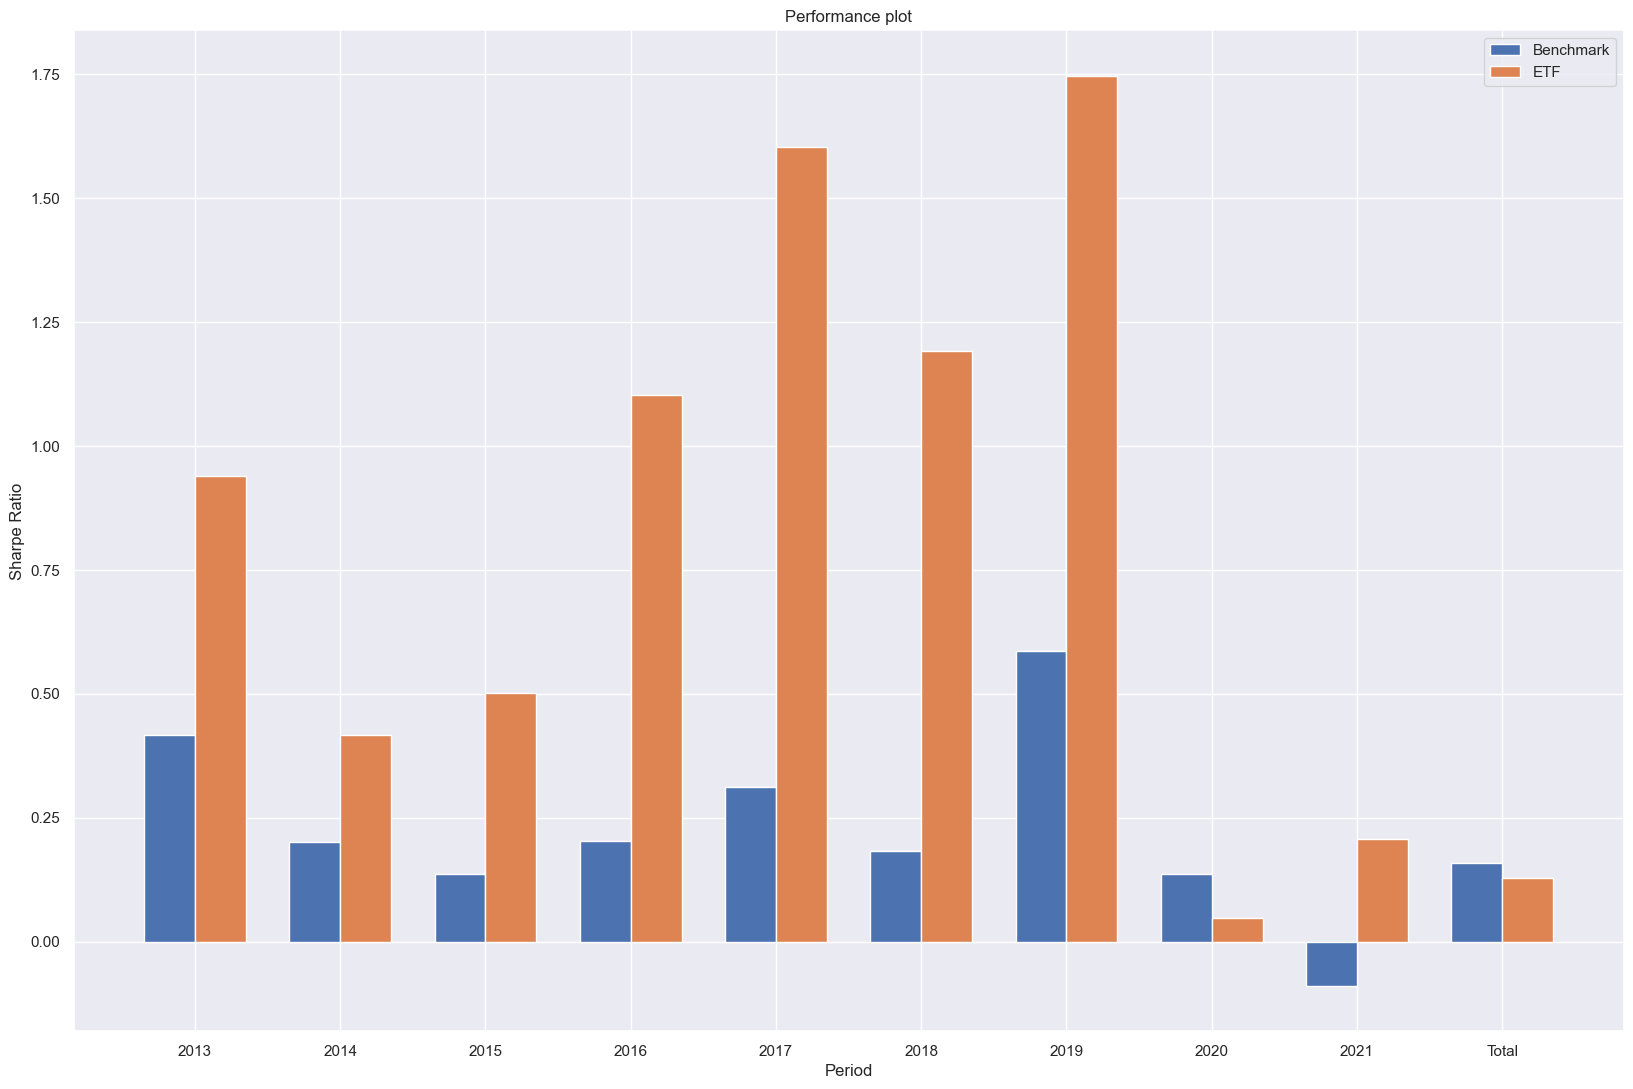

In [18]:
plt.figure(figsize=(20,13))
plt.title('Performance plot')
bar_width = 0.35
x = np.arange(len(output_df['Period']))
plt.bar(x - bar_width/2, output_df['Sharpe Ratio BMK'], bar_width, label='Benchmark')
plt.bar(x + bar_width/2, output_df['Sharpe Ratio ETF'], bar_width, label='ETF')

# Add labels, title, and legend
plt.xlabel('Period')
plt.ylabel('Sharpe Ratio')
plt.xticks(x, output_df['Period'])
plt.legend()

In [19]:
output_df.to_csv('performance_metrics.csv', index=False)